In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s - loss: 190.6084 - val_loss: 172.9074
Epoch 2/50
60000/60000 [==============================] - 2s - loss: 169.9962 - val_loss: 167.9087
Epoch 3/50
60000/60000 [==============================] - 2s - loss: 166.8622 - val_loss: 165.7385
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 164.8373 - val_loss: 164.2379
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 163.3662 - val_loss: 162.8577
Epoch 6/50
60000/60000 [==============================] - 2s - loss: 162.1141 - val_loss: 161.6538
Epoch 7/50
60000/60000 [==============================] - 2s - loss: 161.0152 - val_loss: 160.6362
Epoch 8/50
60000/60000 [==============================] - 2s - loss: 159.9668 - val_loss: 159.7043
Epoch 9/50
60000/60000 [==============================] - 2s - loss: 158.9985 - val_loss: 158.9011
Epoch 10/50
60000/60000 [==============================] - 

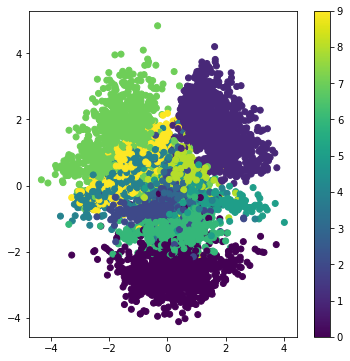

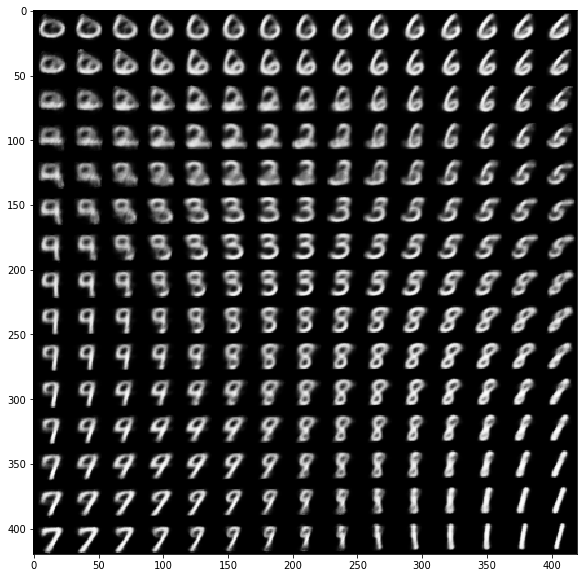

In [2]:
import numpy as np
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

class Hyper(object):
    batch_size = 100
    original_dim = 784
    latent_dim = 2
    intermediate_dim = 256
    epochs = 50
    epsilon_std = 1.0


class MnistVae(object):
    def __init__(self, hyper):
        self.h = hyper

        x, h = self.build_encoder()
        self.vae = self.build_vae(x, h)
        self.generator = self.build_generator()

    def build_optimizer(self):
        return 'rmsprop'
        
    def build_encoder(self):
        x = Input(batch_shape=(None, self.h.original_dim))
        return x, Dense(self.h.intermediate_dim, activation='relu')(x)
    
    def build_sampler(self):
        # it seems that sampling function cannot have references to objects like self.h
        latent_dim = self.h.latent_dim
        epsilon_std = self.h.epsilon_std
        
        def sampling(args):
            z_mean, z_log_var = args
            batch_size = K.shape(z_mean)[0]
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0,
                                      stddev=epsilon_std)
            return z_mean + K.exp(z_log_var / 2) * epsilon
        
        return sampling
    
    def build_vae(self, x, h):
        z_mean = Dense(self.h.latent_dim)(h)
        z_log_var = Dense(self.h.latent_dim)(h)
        sampling = self.build_sampler()
        z = Lambda(sampling, output_shape=(self.h.latent_dim,))([z_mean, z_log_var])

        self.decoder_layers = self.build_decoder_layers()
        x_decoded_mean = self.build_decoder(z)

        def zero_loss(y_true, y_pred):
            return K.zeros_like(y_pred)

        original_dim = self.h.original_dim

        class VariationalLossLayer(Layer):
            def __init__(self, **kwargs):
                self.is_placeholder = True
                super(VariationalLossLayer, self).__init__(**kwargs)

            def vae_loss(self, x, x_decoded_mean):
                xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
                kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
                return K.mean(xent_loss + kl_loss)

            def call(self, inputs):
                x, x_decoded_mean = inputs
                loss = self.vae_loss(x, x_decoded_mean)
                self.add_loss(loss, inputs=inputs)

                return K.ones_like(x)

        loss_layer = VariationalLossLayer()([x, x_decoded_mean])
        vae = Model(x, [loss_layer])
        optimizer = self.build_optimizer()
        vae.compile(optimizer=optimizer, loss=[zero_loss])
        
        self.encoder = Model(x, z_mean)

        return vae
        
    def build_decoder_layers(self):
        decoder_h = Dense(self.h.intermediate_dim, activation='relu')
        decoder_mean = Dense(self.h.original_dim, activation='sigmoid')
        return decoder_h, decoder_mean

    def build_decoder(self, z):
        decoder_h, decoder_mean = self.decoder_layers
        h_decoded = decoder_h(z)
        return decoder_mean(h_decoded)
    
    def build_generator(self):
        decoder_input = Input(shape=(self.h.latent_dim,))
        decoded_mean = self.build_decoder(decoder_input)
        return Model(decoder_input, decoded_mean)

    
h = Hyper()
model = MnistVae(h)
        
model.vae.fit(x_train, x_train,
        shuffle=True,
        epochs=h.epochs,
        batch_size=h.batch_size,
        validation_data=(x_test, x_test))


# display a 2D plot of the digit classes in the latent space
x_test_encoded = model.encoder.predict(x_test, batch_size=h.batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = model.generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()